<a href="https://colab.research.google.com/github/choudhurysibani120/NYC-Trip-Time-Prediction/blob/main/sibani_choudhury_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv')

Peeking at the data

In [4]:
data.shape

(1458644, 11)

There are 1458644 rows and 11 columns

In [5]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
# checking data-types of variables to identify the numerical and categorical variables
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


Categorizing the features :¶

Let's divide features into categories:

Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

Time related: pickup_datetime, dropoff_datetime

Identifier: id(not useful for analysis)

Others: vendor_id, passenger_count, store_and_fwd_flag

Target: trip_duration

In [6]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them

NAN or Missing Values

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow

In [7]:

data['trip_duration'].isnull().sum()

0

In [8]:

data.drop_duplicates(inplace=True)
data.shape

(1458644, 11)

There are no null values and duplicate data.

In [9]:
data['passenger_count'].value_counts().reset_index()

,index,passenger_count
0,1,1033540
1,2,210318
2,5,78088
3,3,59896
4,6,48333
5,4,28404
6,0,60
7,7,3
8,9,1
9,8,1


In [10]:
data[data['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [12]:
data=data[data['passenger_count']!=0]

In [13]:
data["pickup_datetime"][0]

'2016-03-14 17:24:55'

In [15]:

data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'])
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


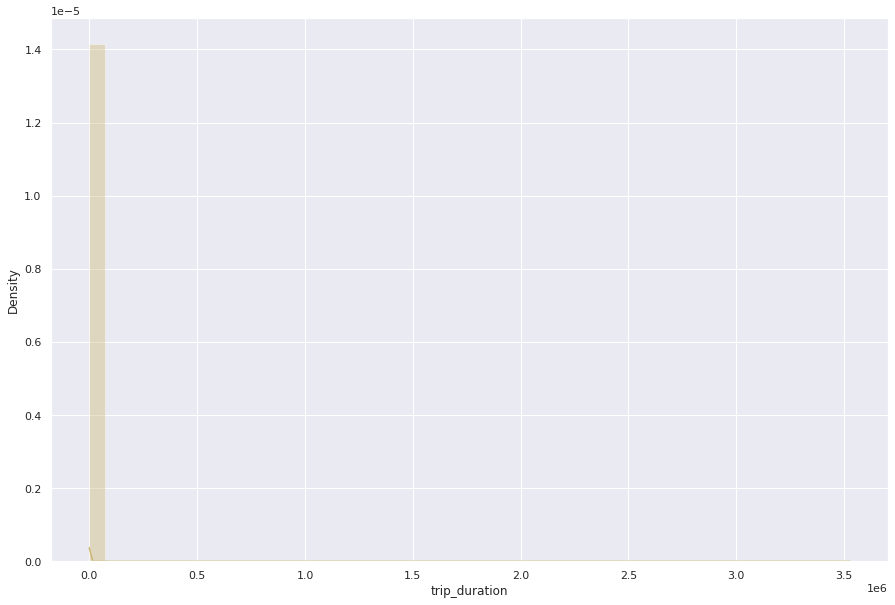

In [16]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(15,10))
sns.distplot(data['trip_duration'],color="y")

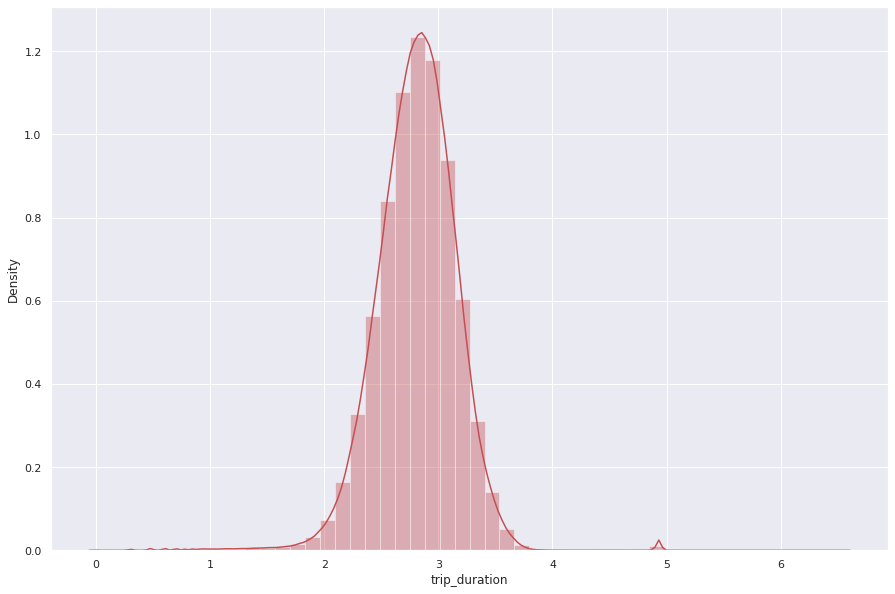

In [17]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(data['trip_duration']),color="R")

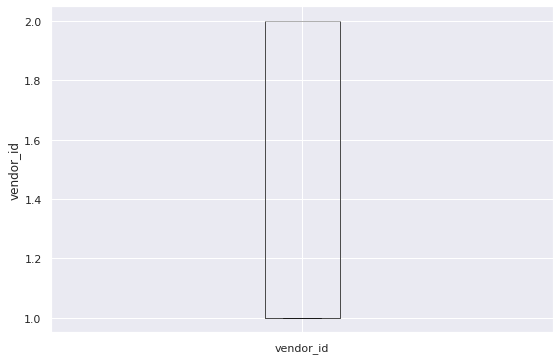

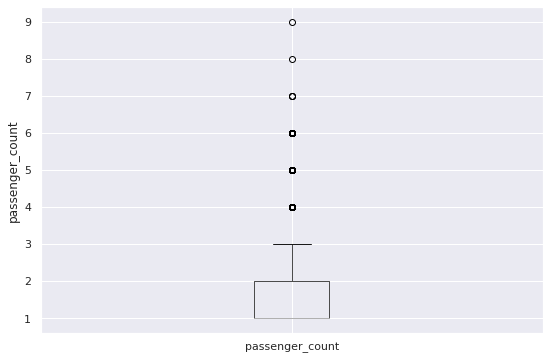

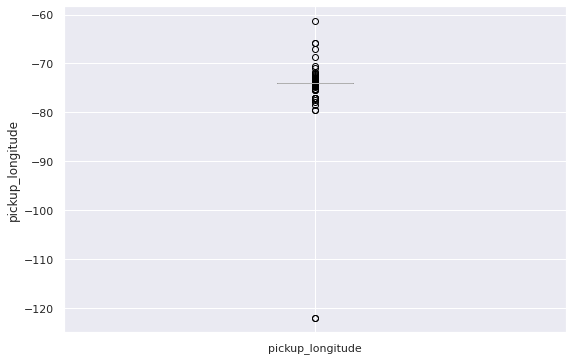

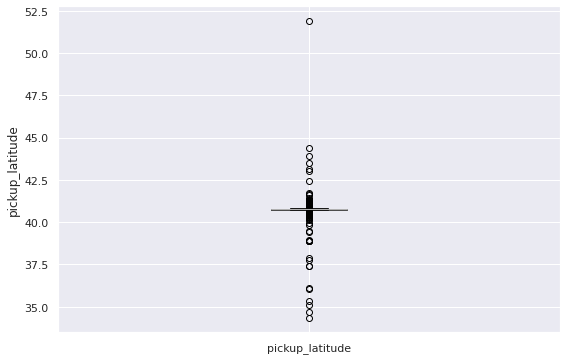

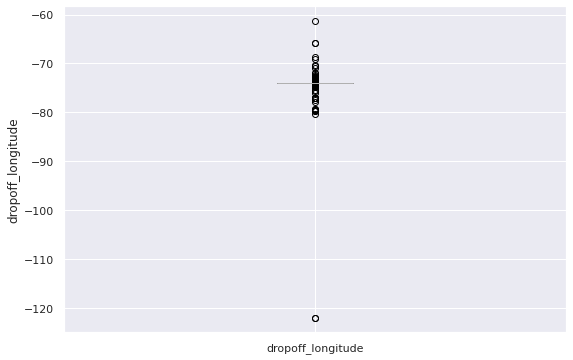

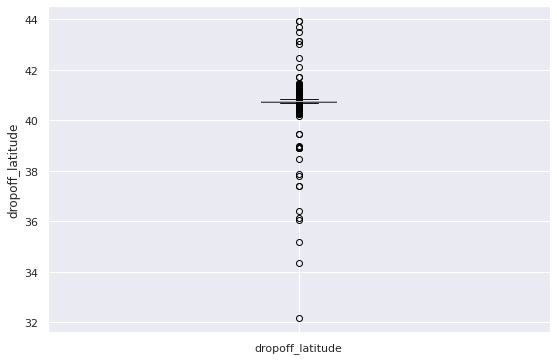

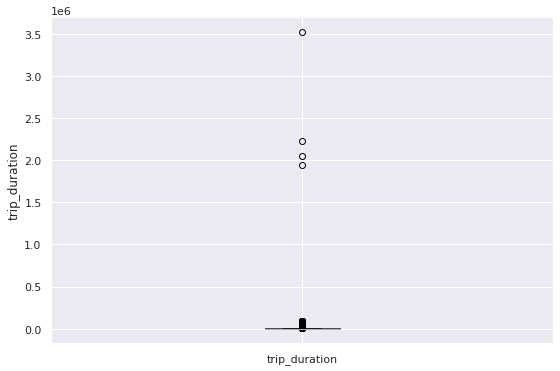

In [18]:
# plot a boxplot for the label by each numerical feature  
for col in data.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  data.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

In [19]:
numeric_features = data.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

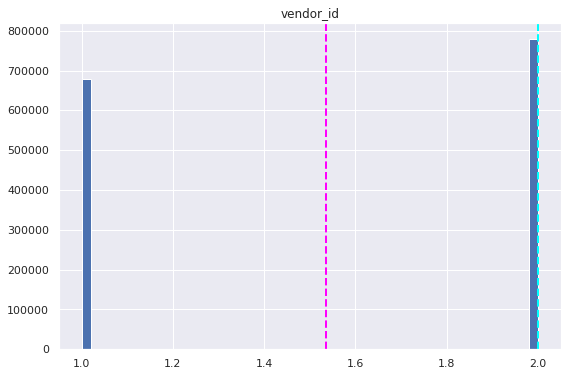

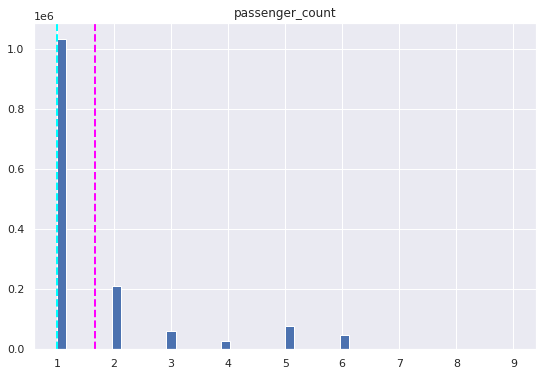

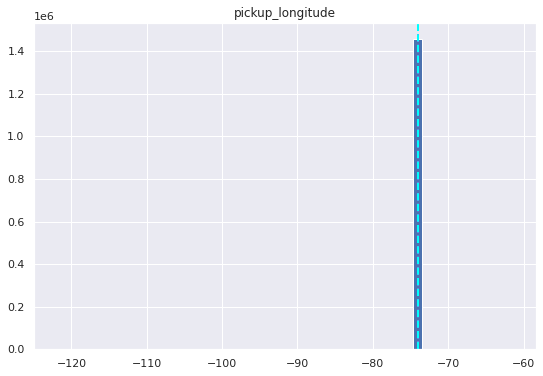

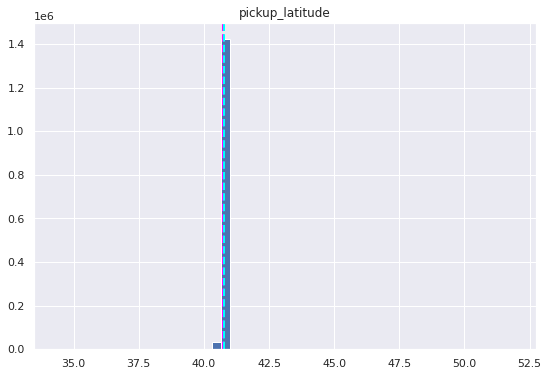

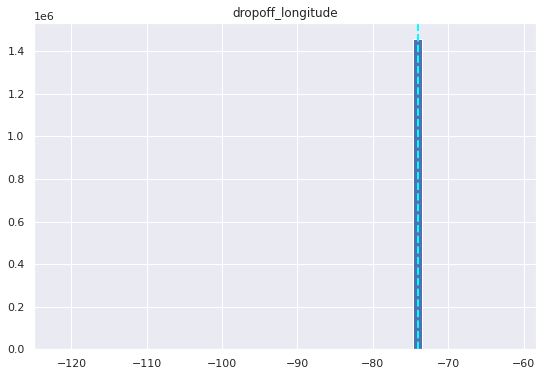

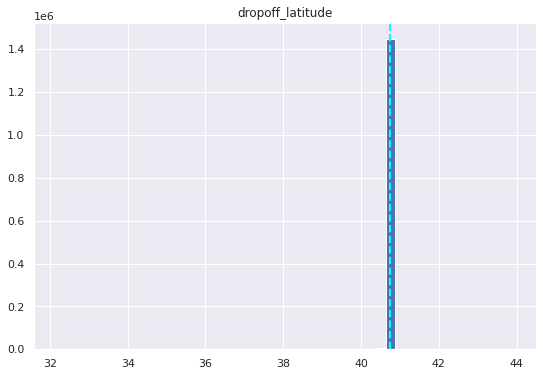

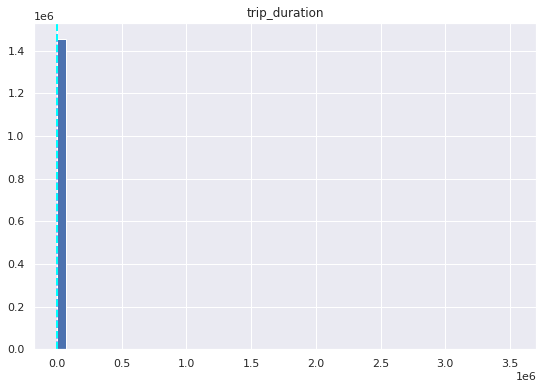

In [20]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

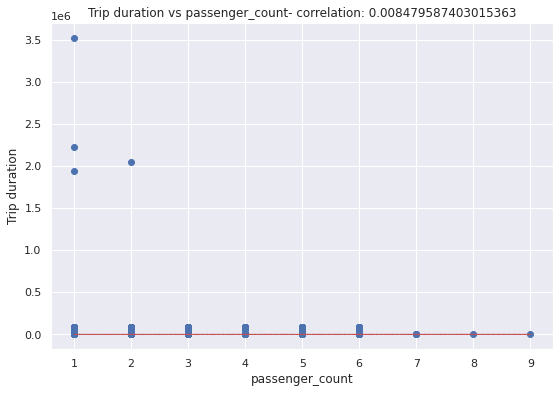

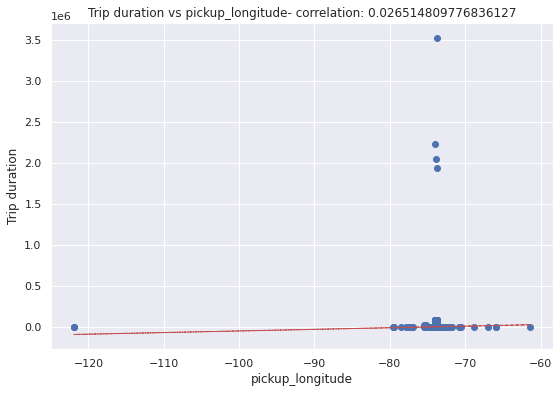

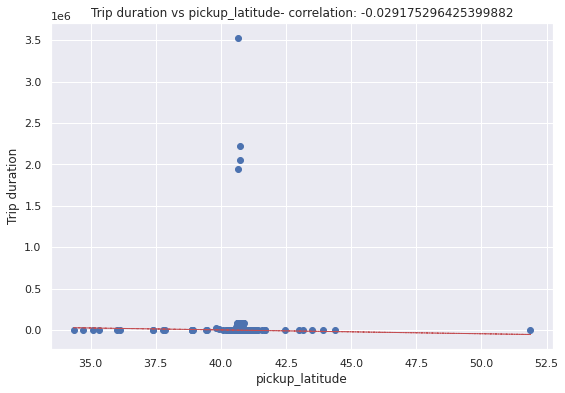

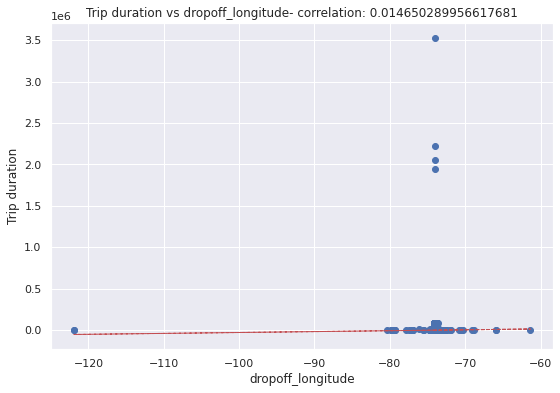

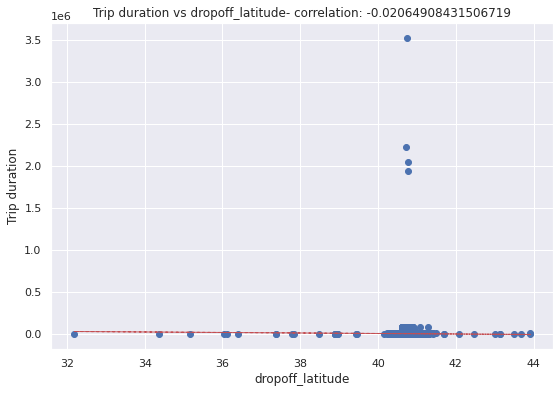

In [24]:

for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    label = data['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(data[col], data['trip_duration'], 1)
    y_hat = np.poly1d(z)(data[col])

    plt.plot(data[col], y_hat, "r--", lw=1)

plt.show()

(-74.03, -73.75)

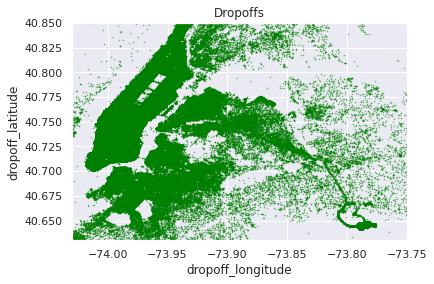

In [25]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

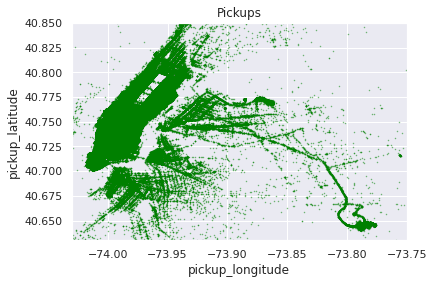

In [26]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Pickups')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [27]:
def select_within_boundingbox(df, BB):
    return ((data["pickup_longitude"] >= BB[0]) & (data["pickup_longitude"] <= BB[1]) & 
            (data["pickup_latitude"] >= BB[2]) & (data["pickup_latitude"] <= BB[3]) &
            (data["dropoff_longitude"] >= BB[0]) & (data["dropoff_longitude"] <= BB[1]) &
            (data["dropoff_latitude"] >= BB[2]) & (data["dropoff_latitude"] <= BB[3]))
BB = (-74.3, -73.0, 40.6, 41.7)

FEATURE ENGINEERING

In [29]:
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday


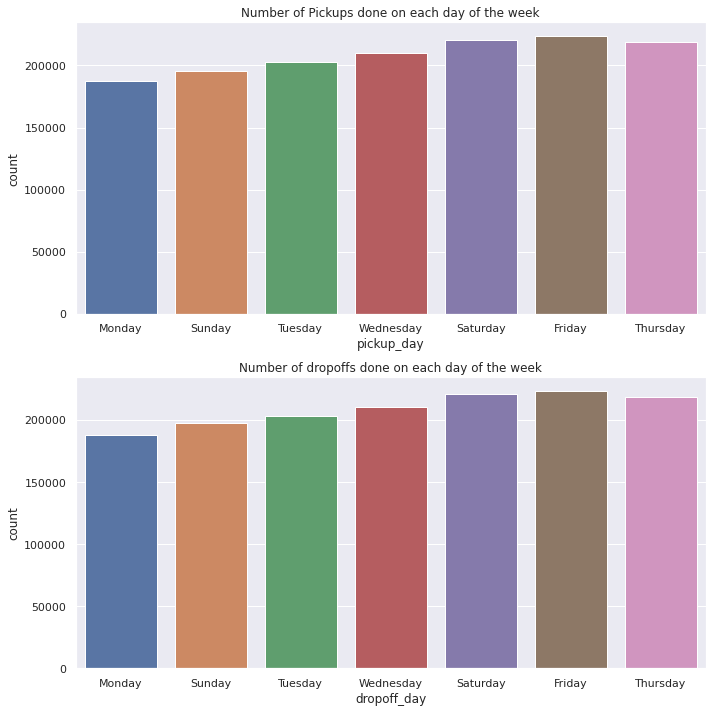

In [31]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=data,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=data,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.

In [32]:
bins=np.array([0,1800,3600,5400,7200,90000])
data['duration_time']=pd.cut(data.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [34]:

import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
data['pickup_timezone']=data['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
data['dropoff_timezone']=data['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

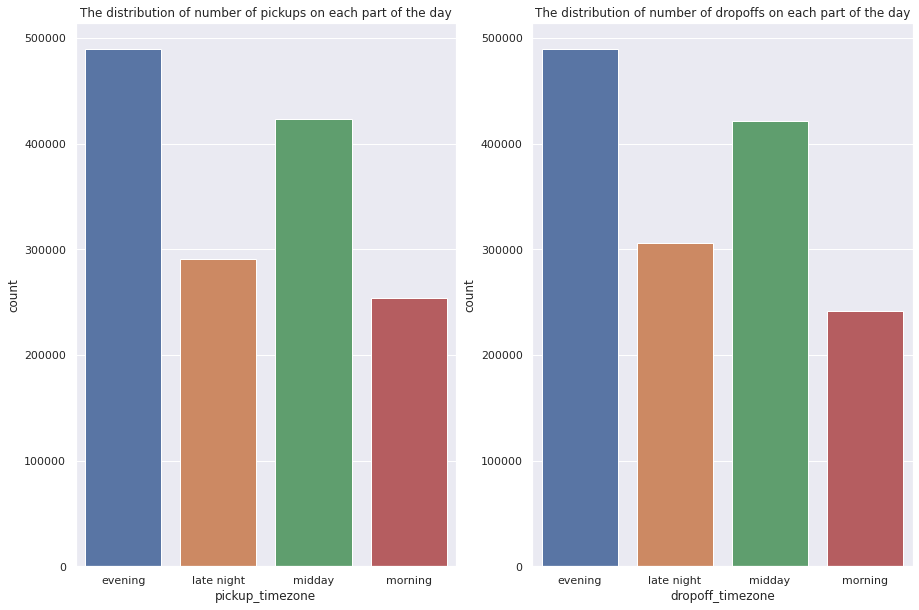

In [35]:

figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=data,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=data,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [36]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [37]:
data["distance"] = data.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)


IQR=Q3-Q1

lower_limit_outlier=Q1-1.5*IQR

upper_limit_outlier=Q3+1.5*IQR¶

so we have to take the values which is greater then lower limit outlier and less then upper limit outlier
remove the outlier present in distance

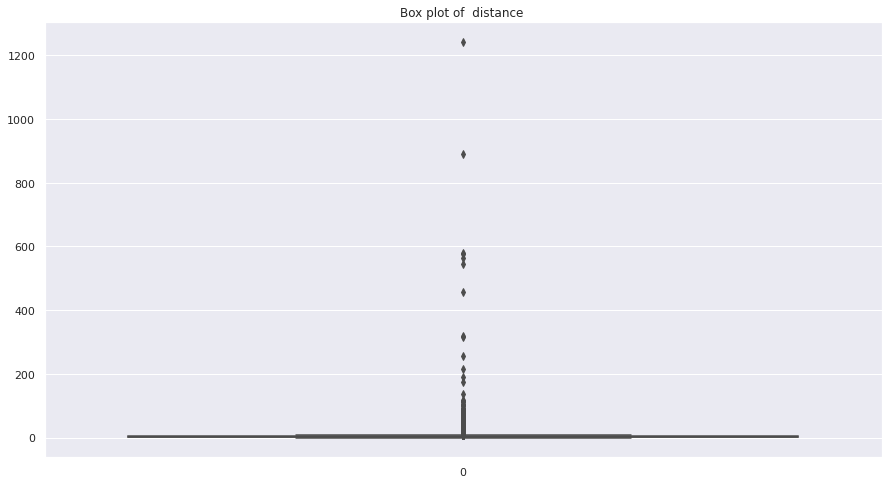

In [38]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=data['distance'], orient="v")

In [39]:
percentile_q1 = np.percentile(data['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(data['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(data['distance'],75)
print(percentile_q3)

1.232295860862315
2.0944392378528622
3.8766616822922098


In [40]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.734252871282527
Upper limit for outlier  : 7.843210414437052


In [41]:
data=data[data['distance']>lower_limit_outlier]
data=data[data['distance']<upper_limit_outlier]

In [42]:
data.shape

(1317917, 17)

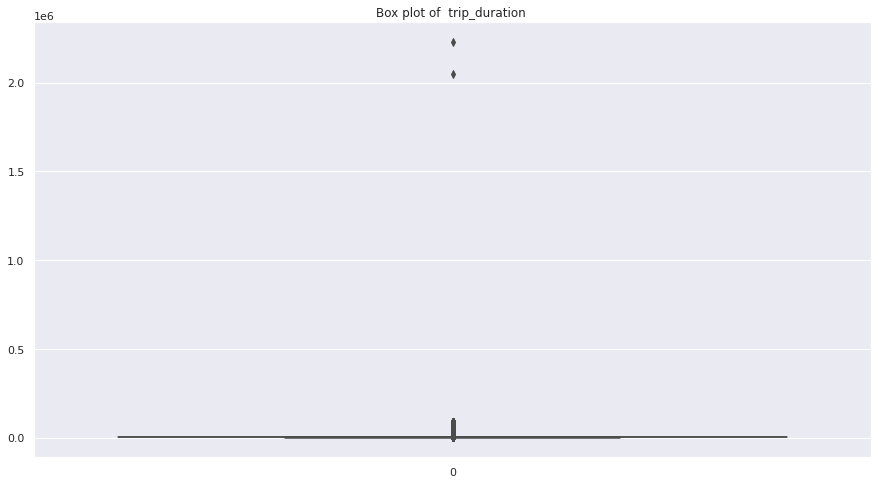

In [43]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=data['trip_duration'], orient="v")

In [44]:
percentile_q1_trip_duration = np.percentile(data['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(data['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(data['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [45]:

iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [46]:

data=data[data['trip_duration']>0]
data=data[data['trip_duration']<upper_limit_outlier_trip_duration]

In [47]:
data.shape

(1277345, 17)

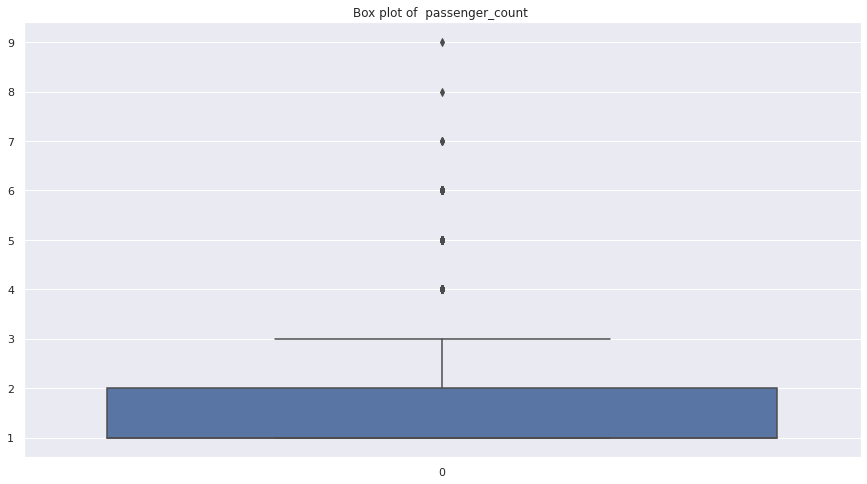

In [48]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=data['passenger_count'], orient="v")

In [49]:
percentile_q1_passenger_count = np.percentile(data['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(data['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(data['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [51]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [52]:

data=data[data['passenger_count']>0]
data=data[data['passenger_count']<upper_limit_outlier_passenger_count]

In [53]:
data.shape

(1142605, 17)

In [54]:

data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [55]:
data['Day']=data['pickup_datetime'].dt.day_name()

In [56]:
data["year"] = data["pickup_datetime"].apply(lambda x: x.year)
data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
data["day_num"] = data["pickup_datetime"].apply(lambda x: x.day)
data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)

Converting trip duration into hours.

Taking log of our distance for normalisation of data.

Taking log of our trip duration as well to normalize it's data too.

In [57]:
data['trip_duration_hour']=data['trip_duration']/3600
data['log_distance']=np.log(data.distance)
data['log_trip_duration']=np.log(data.trip_duration_hour)

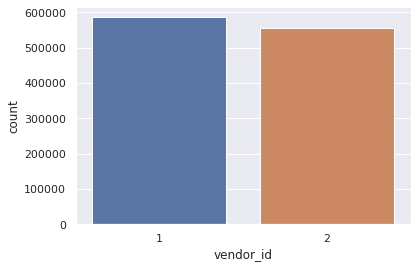

In [60]:
sns.countplot(x='vendor_id',data=data)

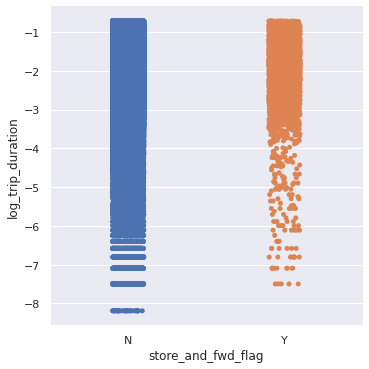

In [61]:

sns.catplot(x="store_and_fwd_flag", y="log_trip_duration",kind="strip",data=data)

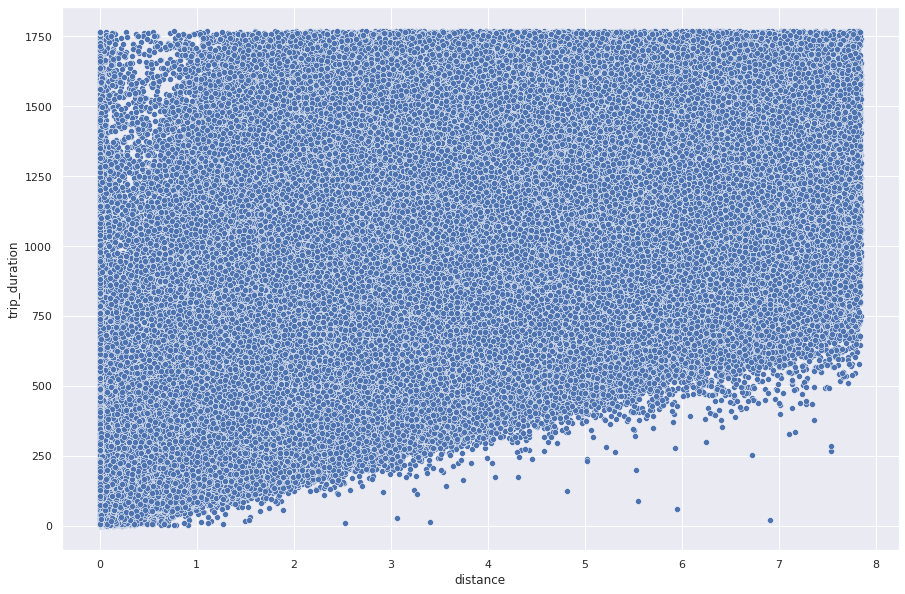

In [62]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=data)

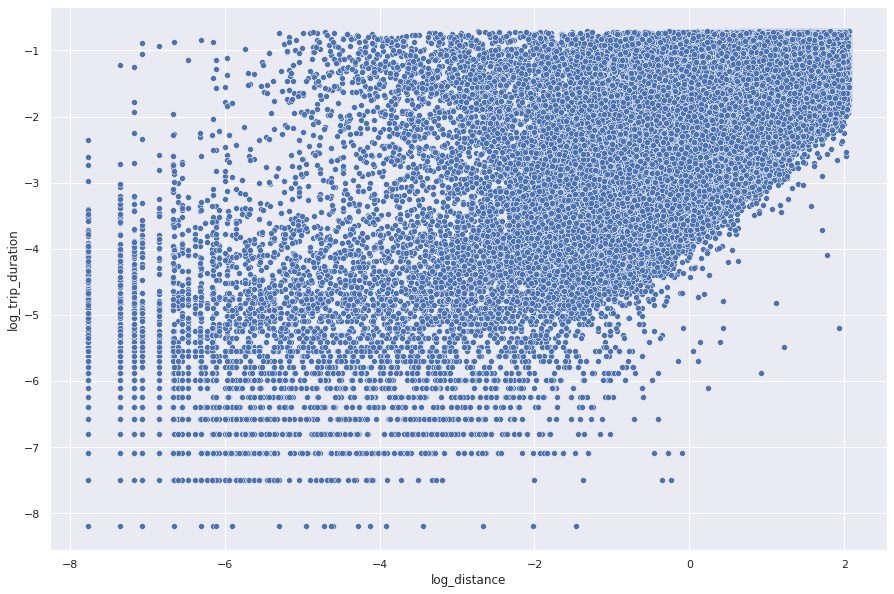

In [63]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=data)

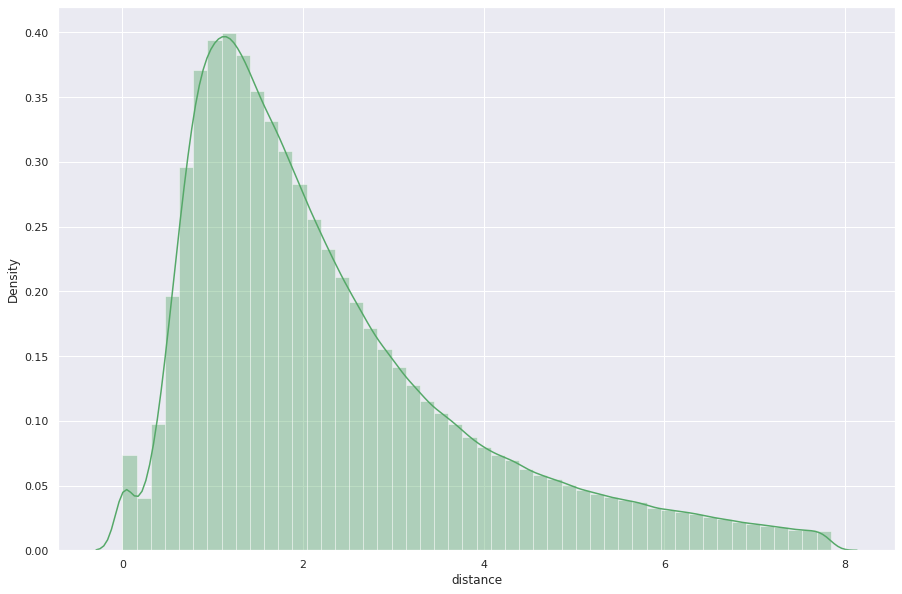

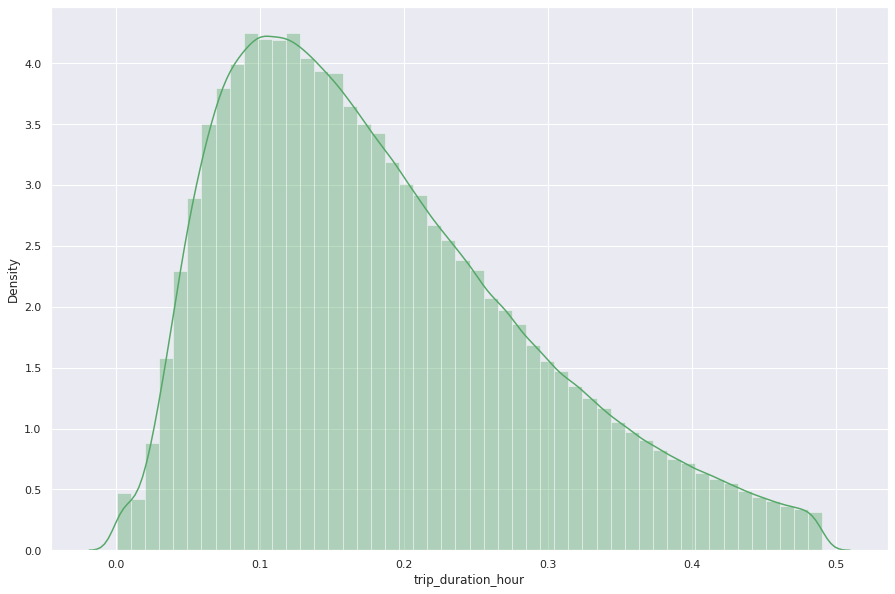

In [64]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(data[i],color="g")

In [65]:
# One hot encoding
data= pd.get_dummies(data, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [66]:

features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [68]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_data=data[newdata]

In [70]:

from scipy.stats import zscore
#Train test split
X = data[features].apply(zscore)[:100000]
y=data['trip_duration_hour'][:100000]

In [71]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [74]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


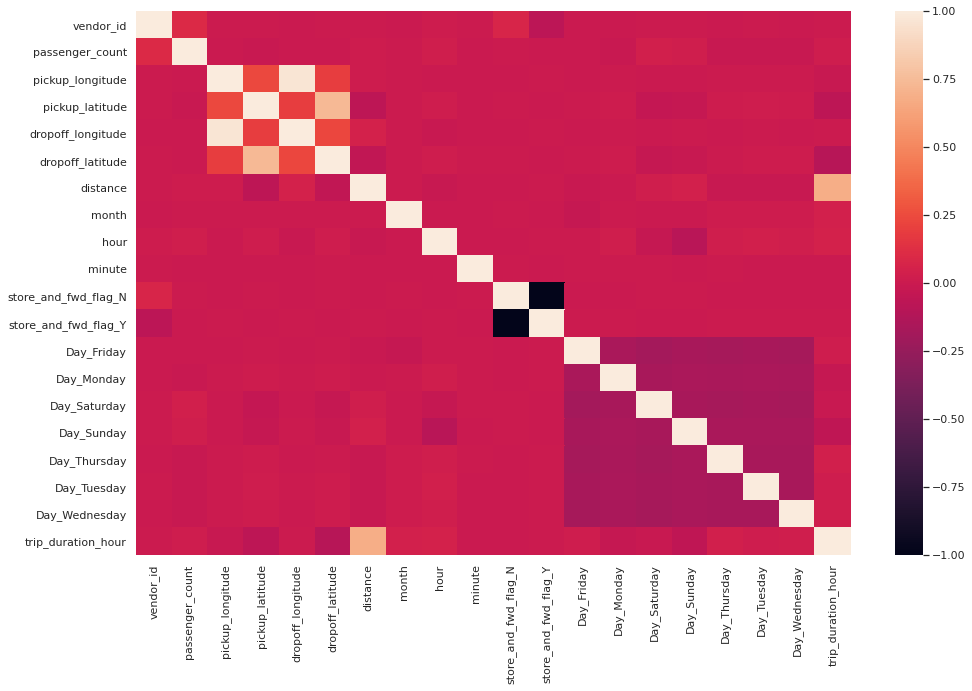

In [76]:
plt.figure (figsize= (16,10))
sns.heatmap(trip_data.corr())

In [77]:

reg = LinearRegression().fit(X_train, y_train)

In [78]:
reg.score(X_train, y_train)

0.4977717521753691

In [79]:
y_pred_train = reg.predict(X_train)

In [80]:
y_pred_test = reg.predict(X_test)

In [81]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.005544800863815122
RMSE : 0.07446341963551716
R2 : 0.49777175217536906
Adjusted R2 :  0.4976524431392517


In [82]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.0054712642758744994
RMSE : 0.07396799494291095
R2 : 0.49593024351436577
Adjusted R2 :  0.4954508979000902


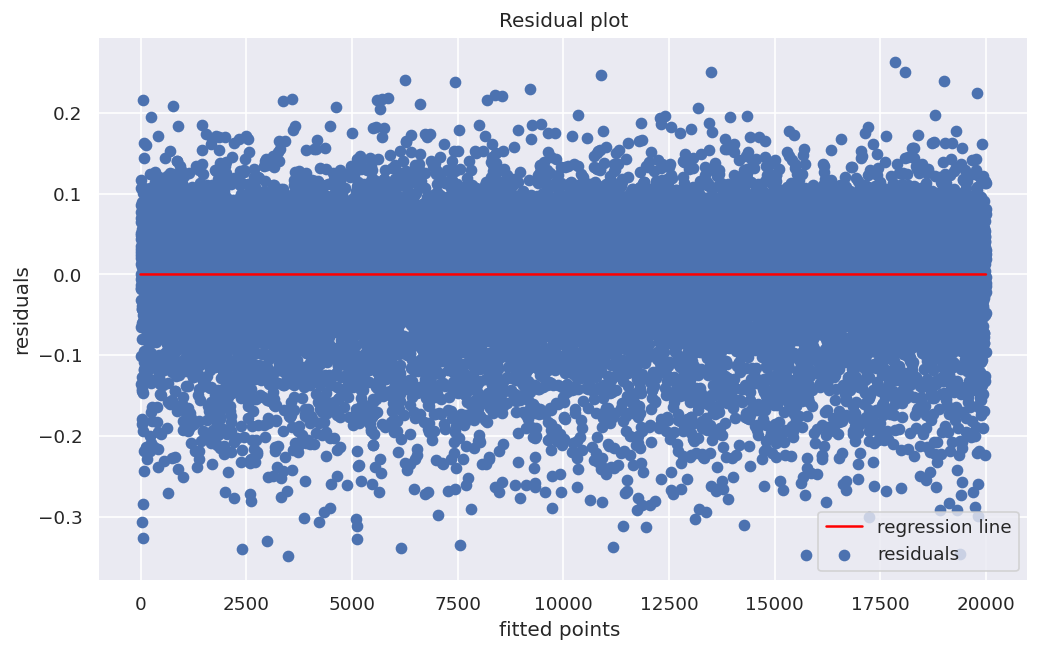

In [83]:
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()